# <center>GBDT</center>

## 一、引言 

　　GBDT(Gradient Boosting Decision Tree) 是一种迭代的决策树算法,又叫MART (Multiple Additive Regression Tree),它通过构造一组弱的学习器(树),并把多颗决策树的结果累加起来作为最终的预测输出.该算法将决策树与集成学习进行了有效的结合.

　　GBDT的思想使其具有天然优势可以发现多种有区分性的特征以及特征组合.自算法的诞生之初,它就和SVM一起被认为是泛化能力(geteralization)较强的算法.近些年来更因为被用于构建搜索排序的机器学习模型而引起广泛的关注.它最早见于yahoo,后被广泛应用于搜索排序、点击率预估上.业界中,Facebook使用其来自动发现有效的特征、特征组合,来作为LR模型中的特征,以提高CTR预估(Click-Through Rate Prediction)的准确性;GBDT在淘宝的搜索及预测业务上也发挥了重要作用.

　　本文首先介绍GBDT中的DT,即回归树,这是它的基础算法;然后叙述提升树,它是以决策树为基函数的提升方法;接着介绍GBDT中的GB,即梯度提升;最后导出GBDT算法的整个流程.

## 二、Regression Decision Tree: 回归树

### 2.1 回归树简介

　　树模型也分为决策树和回归树,决策树常用于分类问题,回归树常用于预测问题.决策树常用于分类标签值,比如用于性别、网页是否是垃圾页面、用户是不是作弊;而回归树常用于预测真实数值,比如用户的年龄、用户点击的概率、网页相关程度等等.

　　回归树总体流程类似于分类树,区别在于,回归树的每一个节点都会得到一个预测值,以年龄为例,该预测值等于属于这个节点的所有人年龄的平均值.分枝时穷举每一个feature的每个阈值寻找最优切分变量和最优切分点,但衡量的准则不再是分类树中的基尼系数,而是平方误差最小化.也就是被预测错误的人数越多,平方误差就越大,通过最小化平方误差找到最可靠的分枝依据.分枝知道每个叶子节点上人的年龄都唯一或者达到预设的终止条件(如叶子个数上限),若最终叶子节点上人的年龄不唯一,则以该节点上所有人的平均年龄做为该叶子节点的预测年龄.

　　由于GBDT的核心在于累加所有树的结果做为最终结果,而分类树得到的离散分类结果对于预测分类并不是这么的容易叠加(稍等后面会看到,其实并不是简单的叠加,而是每一步每一棵树的残差和悬着分裂点评价方式都经过公式推导得到的),而对于基于回归树所得到的数值进行加减是有意义的(例如10岁+5岁-3岁=12岁),这是区别分类树的一个显著特征(毕竟男+女=是男是女?这样的运算是毫无道理的),GBDT在运行时使用到了回归树的这个性质,它将累加所有树的结果作为最终结果.所以GBDT中的树都是回归树,而不是分类树,它用来做回归预测,当然回归树经过调整之后也能用来做分类.

### 2.2 回归树的生成

首先看一个简单的回归树生成实例:

/home/xiagte/opt/bin/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


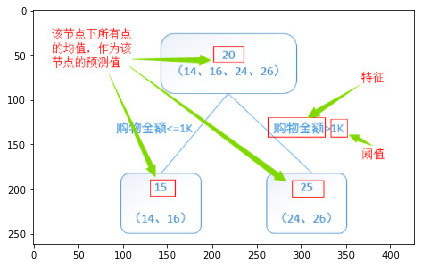

In [2]:
from skimage import io
img=io.imread('./GBDT.jpg')
io.imshow(img)

　　接下来具体说说回归树是如何进行特征选择生成二叉回归树的.

　　假设X与Y分别为输入和输出变量,并且Y是连续变量,给定训练数据集

$$D=\{(x_1,y_1),(x_2,y_2),\cdots,(x_N,y_N)\}$$

　　我们利用最小二乘回归树生成算法来生成回归树$f(x)$,即在训练数据集所在的输入空间中,递归地将每个区域分为两个子区域并决定每个子区域上的输出值,构建二叉决策树,步骤如下:

- 1) 选择最优切分变量j与切分点s,求解:

$$\min_{j,s}[\min_{c_1} \sum_{x_i \in R_1(j,s)}(y_i-c_1)^2 + \min_{c_2}\sum_{x_i \in R_2(j,s)}(y_i-c_i)^2]$$

　　遍历变量j,对固定的切分变量$j$扫描切分点s,选择使上式达到最小值的对$j,s$

- 2) 用选定的对$(j,s)$划分区域并决定相应的输出值:

$$R_1(j,s)=\{x|x^{(j)} \leq s\}\ ,\ R_2(j,s)=\{x|x^{(j)} > s\}$$

$$\hat c_m=\frac{1}{N_m}\sum_{x_i \in R_2(j,s)}y_i\ ,\ x \in R_m\ ,\ m=1,2$$

- 3) 继续对两个子区域调用步骤(1),(2)直至满足停止条件

- 4) 将输入空间划分为$M$个区域$R_1,R_2,\cdots,R_M$,在每个单元$R_m$上有一个固定的输出值$c_m$,生成决策树:

$$f(x)=\sum_{m=1}^M \hat c_m I(x \in R_m)$$

## 三、Boosting Decsion Tree: 提升树

### 3.1提升树模型

　　提升方法采用加法模型(即基函数的线性组合)与前向分布算法.以决策树为基函数的提升方法称为提升树(Boosting tree).对分类问题构建的决策树是二叉分类树,对回归树问题构建决策树是二叉回归树.提升树是迭代多颗回归树来共同决策.当采用平方误差损失函数时,每一颗回归树学习的是之前所有树的结论和残差,拟合得到一个当前的残差回归树,残差的意义如公式: 残差=真实值-预测值.提升树即是整个迭代过程生成的回归树的累加.提升树模型可以表示为决策树的加法模型:

$$f_M(x)=\sum_{m=1}^M T(x;\Theta_m)$$

其中$T(x;\Theta_m)$表示决策树;$\Theta_m$为决策树的参数;$M$为树的个数

### 3.2提升树算法

　　对回归问题的提升树算法来说,给定当前模型$f_{m-1}(x)$只需要简单地拟合当前模型的残差.现将回归问题的提升树算法叙述如下:

- 1) 初始化$f_0(x)=0$

- 2) 对$m=1,2,\cdots,M$

    a) 计算残差

$$r_{mi}=y_i - f_{m-1}(x)\ ,\ i=1,2,\cdots,N$$

    b)拟合残差$r_{m}$学习一个回归树,得到$T(x;\Theta_m)$

    c) 更新$f_m(x)=f_{m-1}(x)+T(x;\Theta_m)$

- 3) 得到回归问题提升树

$$f_M(x)=\sum_{m=1}^M T(x;\Theta_m)$$

接下来通过训练一个用于预测年龄的模型来展现算法的运行流程

- 1) 首先,训练集有4个人A,B,C,D,它们的年龄分别是14,16,24,26,其中A,B分别是高一和高三学生;C,D分别是应届毕业生和工作两年的员工,可用于分枝的特征包括上网时长、购物金额、上网时段和对百度知道的使用方式.如果是一个传统的回归决策树来训练,会得到下图所示结果:

/home/xiagte/opt/bin/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


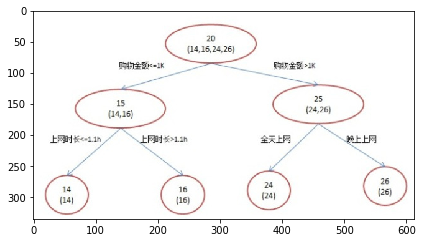

In [2]:
from skimage import io
img=io.imread('./regression_tree.jpg')
io.imshow(img)

- 2) 但是如果用GBDT来做这件事,由于数据太少,我们限定叶子节点最多有两个,即每棵树都只有一个分枝,并且只限定两棵树.我们会得到如下所示结果:

/home/xiagte/opt/bin/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


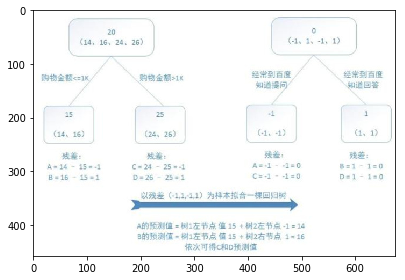

In [3]:
from skimage import io
img=io.imread('./GBDT_example.jpg')
io.imshow(img)

　　第一棵树的分枝与之前一样,也是使用购物金额进行区分,两拨人各自用年龄均值作为预测值,得到残差值-1、1、-1、1,然后拿这些残差值替换初始值取训练生成第二棵回归树,如果新的预测值和残差相等,则只需把第二棵树的结论累加到第一课树上就能得到真实年龄了.

　　第一棵树的分枝与之前一样,也是使用购物金额进行区分,两拨人各自用年龄均值作为预测值,得到残差值-1、1、-1、1,然后拿这些残差值替换初始值取训练生成第二棵回归树,如果新的预测值与残差相等,则只需把第二颗树的结论累加到第一棵树上就能得到真是年龄了.

　　第二颗树只有两个值-1和1,直接可分为两个节点.此时所有人的残差都是0,即每个人都得到了真实的预测值.

- 3)将两颗回归树预测结果进行汇总,解释如下:

    - A: 14岁高一学生;购物较少;经常问学长问题;预测年龄A=15-1=14  
    - B: 16岁高三学生;购物较少;经常被学弟问问题;预测年龄B=15+1=16  
    - C: 24岁应届毕业生;购物较多,经常问师兄问题;预测年龄C=25-1=24  
    - D: 26岁工作两年员工;购物较多,经常被师弟问问题;预测年龄D=25+1=26

　　对比初始的回归树和GBDT所生成的回归树,可以发现,最终的结果是相同的,那我们为什么还要使用GBDT呢?

    - 答案就是对模型过拟合的考虑.过拟合是指为了让训练集精度更高,学到了很多"仅在训练集上成立的规律",导致换一个数据集后,当前规律的预测精度就不足以使人满意了.毕竟,在训练精度和实际精度(或测试精度)之间,后者才是我们想要真正得到的.

    - 在上面这个例子中,初始的回归树为达到100%精度使用了3个特征(上网时长、时段、网购金额),但观察发现,分枝"上网时长>1.1"很显然过拟合了,不排除恰好A上网1.5h,B上网1小时,所以用上网时间是不是>1.1小时来判断所有人的年龄很显然是有悖常识的

    - 而在GBDT中,两颗回归树仅使用了两个特征(购物金额与对百度知道的使用方式)就实现了100%的预测精度,其分枝依据更合乎逻辑(当然这里是相较于上网时长特征而言),算法在运行中也体现了"如无必要,勿增实体"的奥卡姆剃刀原理

### 3.3提升树实例

　　下表为训练数据,$x$的取值范围为区间$[0.5,10.5]$,$y$的取值范围为区间$[5.0,10.0]$,学习这个回归问题的提升树模型,考虑只用二叉树作为基函数:

/home/xiagte/opt/bin/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


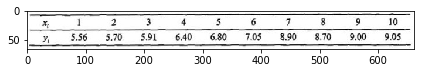

In [4]:
from skimage import io
img=io.imread('./data.jpg')
io.imshow(img)

(1)步骤一:求$f_1(x)$即回归树$T_1(x)$

    1)首先通过以下优化问题:

$$\min_s[\min_{c_1}\sum_{x_i \in R_1}(y_i - c_1)^2 + \min_{c_2}\sum_{x_i \in R_2}(y_i - c_2)^2]$$

    求解训练数据的切分点s:

$$R_1=\{x|x \leq s\},R_2=\{x|x>s\}$$

   容易求得在$R_1$,$R_2$内部使平方误差达到最小值的$c_1$,$c_2$为

$$c_1=\frac{1}{N_1}\sum_{x_i \in R_1}y_i$$

$$c_2=\frac{1}{N_2}\sum_{x_i \in R_2}y_i$$

这里$N_1$,$N_2$是$R_1$,$R_2$的样本点数

    2)具体地,求解训练数据的切分点.根据所给数据,考虑如下切分点:

$$1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5$$

　　对各切分点,不难求出相应的$R_1,R_2,c_1,c_2$及

$$m(x)=\min_{c_1}\sum_{x_i \in R_1}(y_i - c_1)^2 + \min_{c_2}\sum_{x_i \in R_2}(y_i - c_2)^2$$

　　遍历所有的s,计算m(s),结果列表如下:

/home/xiagte/opt/bin/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


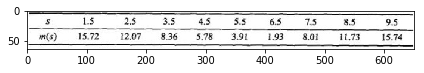

In [6]:
from skimage import io
img=io.imread('./result_1.jpg')
io.imshow(img)

　　可知当$s=6.5$时$m(x)$达到最小值,此时

$$R_1=\{1,2,\cdots,6\}\ ,\ R_2={7,8,9,10}\ ,\ c_1=6.24\ ,\ c_2=8.91$$

　　所以回归树$T_1(x)$为

$$T_2(x)=\{_{8.91\ \ x \geq 6.5}^{6.24\ \ x < 6.5}$$

$$f_1(x)=T_1(x)$$

　　用$f_1(x)$拟合训练数据的残差,表中$r_{2i}=y_i-f_1(x_i)$

/home/xiagte/opt/bin/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


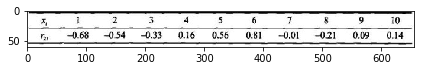

In [7]:
from skimage import io
img=io.imread('./result_2.jpg')
io.imshow(img)

　　平方损失误差为:

$$L(y,f_1(x))=\sum_{i=1}^{10} (y_i - f_1(x_i))^2 = 1.93$$

(2)步骤二:求$T_2(x)$,方法与求$T_1(x)$一样,只是拟合的数据是上一步得到的残差,可以得到:

$$T_2(x)=\{_{0.22\ \ x \geq 3.5}^{-0.52\ \ x < 3.5}$$